In [4]:
import json
import webbrowser

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

from enroads_runner import EnroadsRunner
from evolution.outcomes.outcome_manager import OutcomeManager
from generate_url import actions_to_url
from moo.problems.enroads_problem import EnroadsProblem
from moo.problems.nn_problem import NNProblem

## Setup

In [5]:
context = True
save_path = "results/pymoo/context-updated"
with open(save_path + "/config.json", 'r') as f:
    config = json.load(f)

actions = config["actions"]
outcomes = config["outcomes"]

with open(save_path + "/results", 'rb') as f:
    res = dill.load(f)
    print("Loaded Checkpoint:", res)

X = res.X
F = res.F

# NOTE: Don't use the problem to evaluate because we might run into concurrency issues with read/write.
if not context:
    problem = EnroadsProblem(actions, outcomes)
else:
    context_df = pd.read_csv("experiments/scenarios/gdp_context.csv")
    context_df = context_df.drop(columns=["F", "scenario"])
    problem = NNProblem(context_df, {"in_size": len(context_df.columns), "hidden_size": 16, "out_size": len(actions)}, actions, outcomes)

runner = EnroadsRunner("experiments/temp")
baseline_df = runner.evaluate_actions({})
outcome_manager = OutcomeManager(list(outcomes.keys()))
baseline_metrics = outcome_manager.process_outcomes({}, baseline_df)

Loaded Checkpoint: <pymoo.core.result.Result object at 0x306f91090>
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.


## Convergence Check

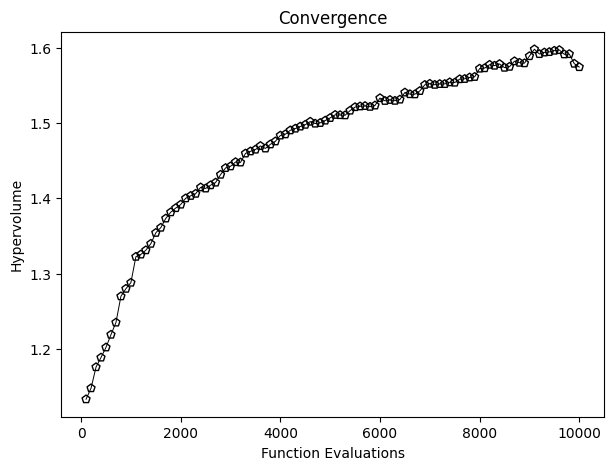

In [6]:
def extract_history(res, save_path=None):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
if save_path:
    plt.savefig(save_path + "/convergence.png", dpi=300)
plt.show()

## Objectives

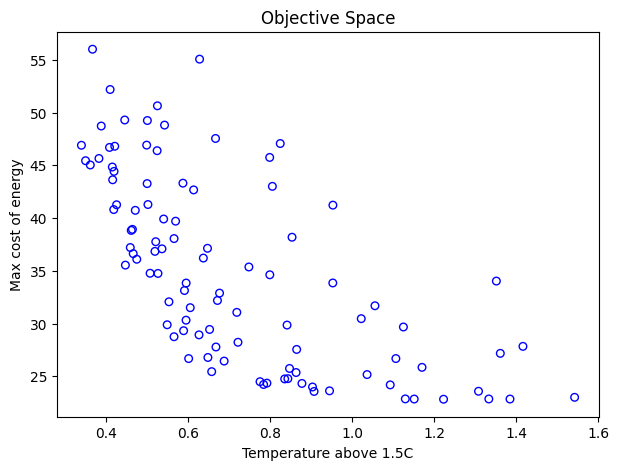

In [7]:
obj_idxs = (0, 1)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, obj_idxs[0]], F[:, obj_idxs[1]], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel(list(outcomes.keys())[obj_idxs[0]])
plt.ylabel(list(outcomes.keys())[obj_idxs[1]])
plt.show()

In [8]:
sample_idxs = set()
for i in range(F.shape[1]):
    sample_idxs.add(F[:,i].argmin())
    sample_idxs.add(F[:,i].argmax())

sample_idxs = list(sample_idxs)
print(sample_idxs)
print(F[sample_idxs])

[0, 1, 2, 3, 4, 5, 6, 7]
[[ 3.66172000e-01  5.60171400e+01  9.54610179e+01  1.79839950e+04]
 [ 3.39128000e-01  4.69066600e+01  1.82670832e+02  2.05869960e+04]
 [ 5.18418000e-01  3.68431000e+01  4.26983202e+02  1.15688378e+04]
 [ 1.35115200e+00  3.40270800e+01  2.75624780e-01  5.57265240e+03]
 [ 6.27272000e-01  5.50755800e+01 -0.00000000e+00  1.17199128e+04]
 [ 1.22233600e+00  2.28197400e+01  4.93134408e+01  7.51762580e+03]
 [ 1.54200800e+00  2.29998000e+01  3.32846907e+01  6.65041260e+03]
 [ 3.81812000e-01  4.56550200e+01  8.25299603e+01  2.18044324e+04]]


In [9]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

sort_col_idx = -1
sample_idxs = evenly_sample(np.argsort(F[:,sort_col_idx]), 9)
print(sample_idxs)
print(F[sample_idxs])

[3, 32, 87, 49, 20, 15, 35, 40, 7]
[[ 1.35115200e+00  3.40270800e+01  2.75624780e-01  5.57265240e+03]
 [ 1.05503800e+00  3.16847200e+01  7.65059110e+01  5.85387260e+03]
 [ 9.52216000e-01  3.38475200e+01  4.01260011e+01  7.61337900e+03]
 [ 8.04830000e-01  4.30106200e+01 -0.00000000e+00  9.42298940e+03]
 [ 5.41840000e-01  4.88199800e+01  2.46512101e+02  1.12278170e+04]
 [ 7.91534000e-01  2.43460800e+01  2.52231987e+02  1.24368212e+04]
 [ 5.68828000e-01  3.97073000e+01  1.17897024e+02  1.47123952e+04]
 [ 4.58268000e-01  3.72066000e+01  8.67990867e+01  1.74360498e+04]
 [ 3.81812000e-01  4.56550200e+01  8.25299603e+01  2.18044324e+04]]


In [10]:
def plot_parallel_coordinates(F, outcomes, cand_idxs, save_path=None):
    coords_dicts = []
    for cand_idx in range(F.shape[0]):
        results_dict = dict(zip(outcomes.keys(), F[cand_idx]))
        if cand_idx in cand_idxs:
            print(results_dict)
        # Since we always minimize we need to flip the sign of outcomes that are maximized.
        for key in results_dict:
            if not outcomes[key]:
                results_dict[key] = -results_dict[key]
        if cand_idx in cand_idxs:
            results_dict["cand_id"] = cand_idx
        else:
            results_dict["cand_id"] = "other"
        coords_dicts.append(results_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "other"], "cand_id", color=["lightgray"])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    condition = (normalized_df["cand_id"] != "other") & (normalized_df["cand_id"] != "Baseline")
    pd.plotting.parallel_coordinates(normalized_df[condition], "cand_id", color=colors)

    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "Baseline"], "cand_id", color="black")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

{'Temperature above 1.5C': 1.3511520000000001, 'Max cost of energy': 34.02708, 'Government net revenue below zero': 0.27562478000000024, 'Total energy below baseline': 5572.652400000001}
{'Temperature above 1.5C': 0.381812, 'Max cost of energy': 45.65502, 'Government net revenue below zero': 82.52996028, 'Total energy below baseline': 21804.432399999998}
{'Temperature above 1.5C': 0.791534, 'Max cost of energy': 24.346079999999997, 'Government net revenue below zero': 252.23198665, 'Total energy below baseline': 12436.821200000002}
{'Temperature above 1.5C': 0.54184, 'Max cost of energy': 48.81998, 'Government net revenue below zero': 246.51210110000002, 'Total energy below baseline': 11227.817}
{'Temperature above 1.5C': 1.0550380000000001, 'Max cost of energy': 31.684720000000006, 'Government net revenue below zero': 76.50591100536526, 'Total energy below baseline': 5853.8726}
{'Temperature above 1.5C': 0.568828, 'Max cost of energy': 39.7073, 'Government net revenue below zero': 117

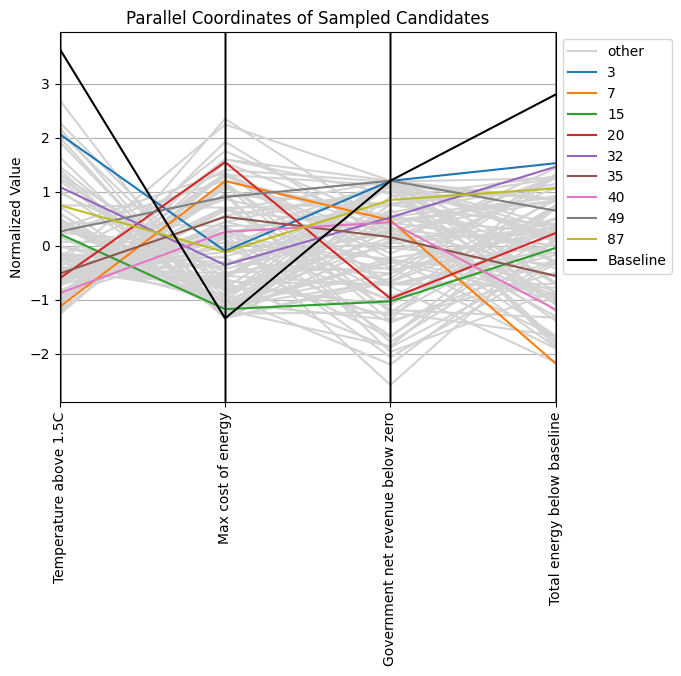

In [11]:
plot_parallel_coordinates(F, outcomes, sample_idxs, save_path=save_path + "/parallel.png")

## Outcomes

In [12]:
if not context:
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        actions_dict = problem.params_to_actions_dict(X[cand_idx])
        outcomes_df = runner.evaluate_actions(actions_dict)
        outcomes_dfs.append(outcomes_df)
else:
    all_outcomes_dfs = []
    all_context_actions_dicts = []
    for cand_idx in range(X.shape[0]):
        context_actions_dicts = problem.params_to_context_actions_dicts(X[cand_idx])
        all_context_actions_dicts.append(context_actions_dicts)
        cand_outcomes_dfs = problem.run_enroads(context_actions_dicts)
        all_outcomes_dfs.append(cand_outcomes_dfs)

In [13]:
def get_single_context_outcomes(all_outcomes_dfs: list[list[pd.DataFrame]], context_idx: int) -> list[pd.DataFrame]:
    outcomes_dfs = []
    for cand_outcomes_dfs in all_outcomes_dfs:
        outcomes_dfs.append(cand_outcomes_dfs[context_idx])
    return outcomes_dfs

def get_average_outcomes(all_outcomes_dfs: list[list[pd.DataFrame]]) -> list[pd.DataFrame]:
    outcomes_dfs = []
    for cand_outcomes_dfs in all_outcomes_dfs:
        concat_df = pd.concat(cand_outcomes_dfs, axis=0, keys=range(len(cand_outcomes_dfs)))
        average_df = concat_df.groupby(level=1).mean()
        outcomes_dfs.append(average_df)
    return outcomes_dfs

if context:
    outcomes_dfs = get_average_outcomes(all_outcomes_dfs)

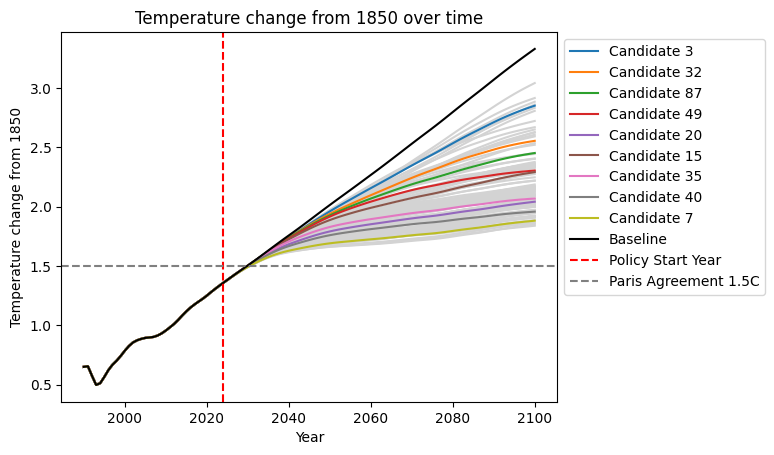

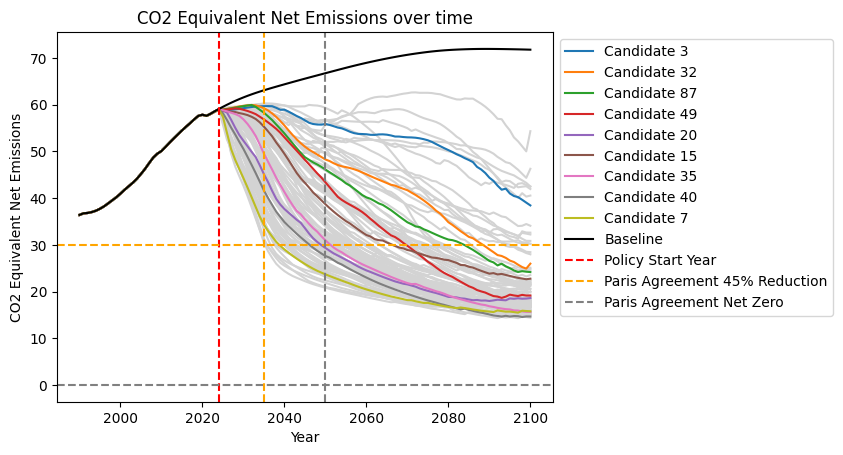

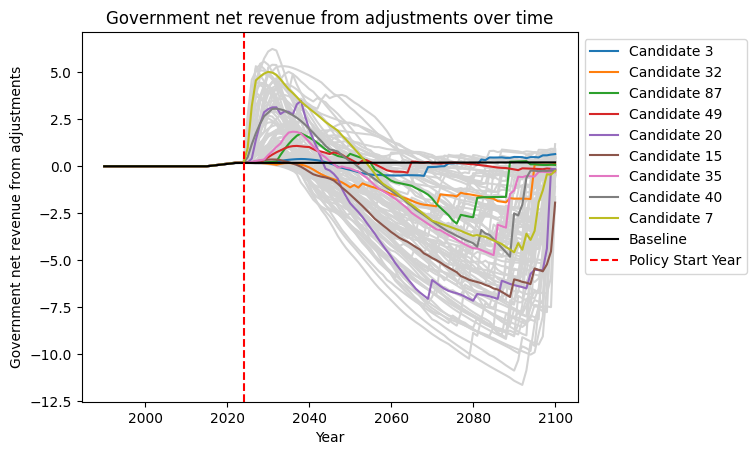

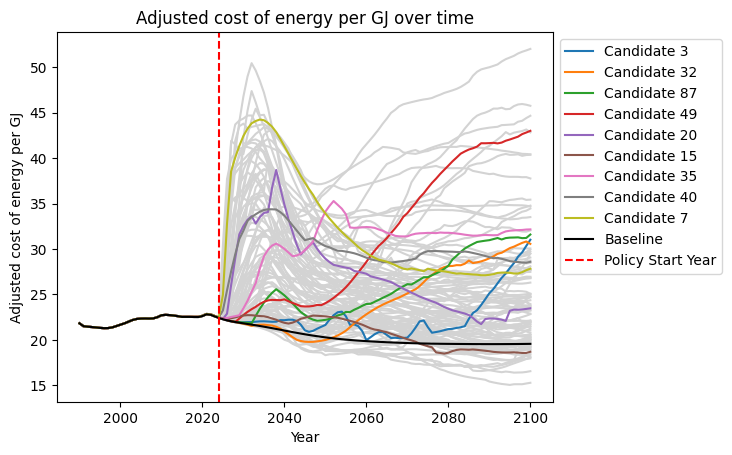

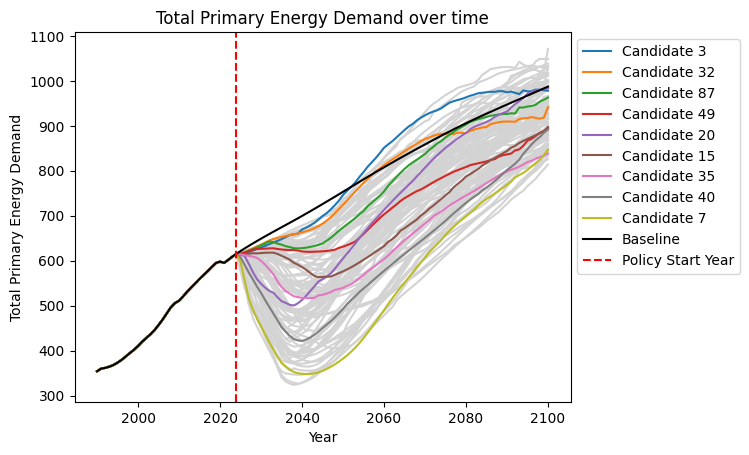

In [14]:
def plot_outcome_over_time(outcomes: list[str],
                           cand_idxs: list[int],
                           outcomes_dfs: list[pd.DataFrame],
                           baseline_df: pd.DataFrame,
                           save_path=None):
    for outcome in outcomes:
        for cand_idx in range(X.shape[0]):
            if cand_idx not in cand_idxs:
                plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], color="lightgray")
        for cand_idx in cand_idxs:
            plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], label=f"Candidate {cand_idx}")
        plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
        plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

        if outcome == "CO2 Equivalent Net Emissions":
            plt.axhline(y=0, color="gray", linestyle="--")
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

        elif outcome == "Temperature change from 1850":
            plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

        plt.legend(bbox_to_anchor=(1, 1))
        plt.title(f"{outcome} over time")
        plt.xlabel("Year")
        plt.ylabel(outcome)
        if save_path:
            plt.savefig(save_path + f"/{outcome.replace(' ', '-')}.png", bbox_inches='tight', dpi=300)
        plt.show()

plot_outcomes = ["Temperature change from 1850", "CO2 Equivalent Net Emissions", "Government net revenue from adjustments", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
plot_outcome_over_time(plot_outcomes, sample_idxs, outcomes_dfs, baseline_df, save_path=save_path)

In [15]:
def plot_energy_usage(cand_idxs: list[int], outcomes_dfs: list[pd.DataFrame], baseline_df: pd.DataFrame, save_path=None):
    fig, axes = plt.subplots(1, len(cand_idxs), sharey=True, figsize=(7.5 * len(cand_idxs), 5))
    if len(cand_idxs) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_idxs, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand_outcomes = outcomes_dfs[cand_id]
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    if save_path:
        plt.savefig(save_path + "/energy.png", dpi=300)
    plt.show()

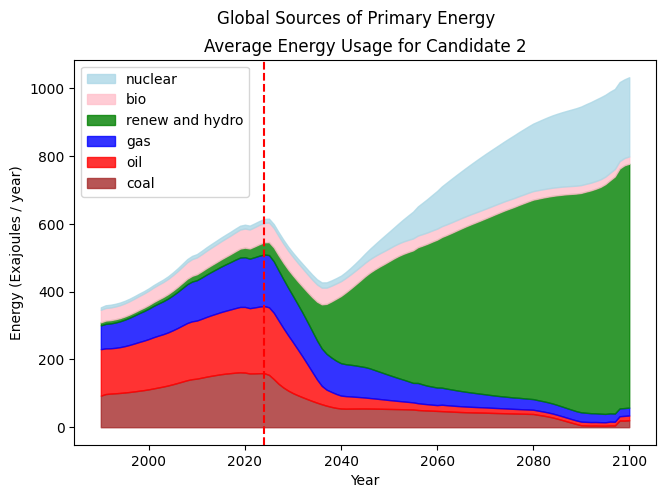

In [16]:
plot_energy_usage([2], outcomes_dfs, baseline_df)

In [17]:
def open_idx(cand_idx: int, X: np.ndarray, problem: EnroadsProblem):
    actions_dict = problem.params_to_actions_dict(X[cand_idx])
    url = actions_to_url(actions_dict)
    webbrowser.open(url)

def open_context_idx(cand_idx: int, X: np.ndarray, problem: NNProblem, context_idx: int):
    context_actions_dicts = problem.params_to_context_actions_dicts(X[cand_idx])
    url = actions_to_url(context_actions_dicts[context_idx])
    webbrowser.open(url)

In [18]:
if not context:
    open_idx(113, X, problem)
else:
    open_context_idx(sample_idxs[0], X, problem, 0)

## Compare Contexts

In [19]:
cand_idx = sample_idxs[5]
ssp_1_outcomes = get_single_context_outcomes(all_outcomes_dfs, 0)
ssp_3_outcomes = get_single_context_outcomes(all_outcomes_dfs, 2)

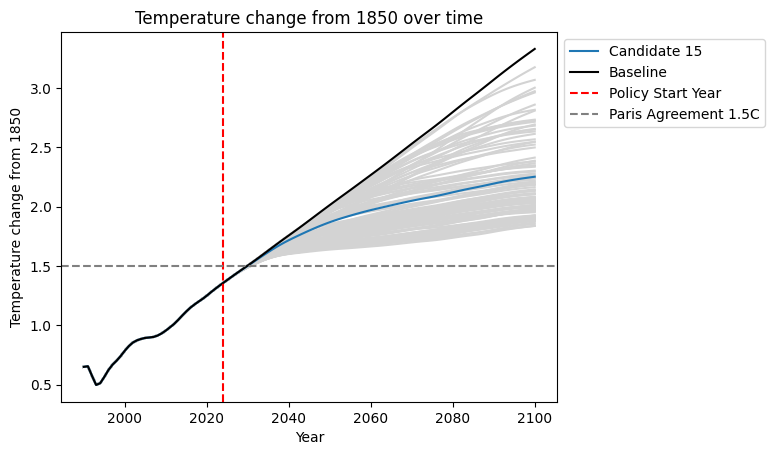

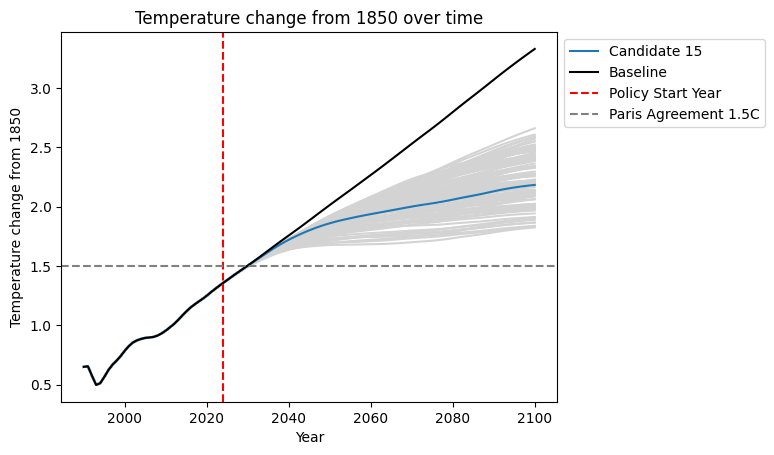

In [20]:
plot_outcome_over_time([plot_outcomes[0]], [cand_idx], ssp_1_outcomes, baseline_df)
plot_outcome_over_time([plot_outcomes[0]], [cand_idx], ssp_3_outcomes, baseline_df)

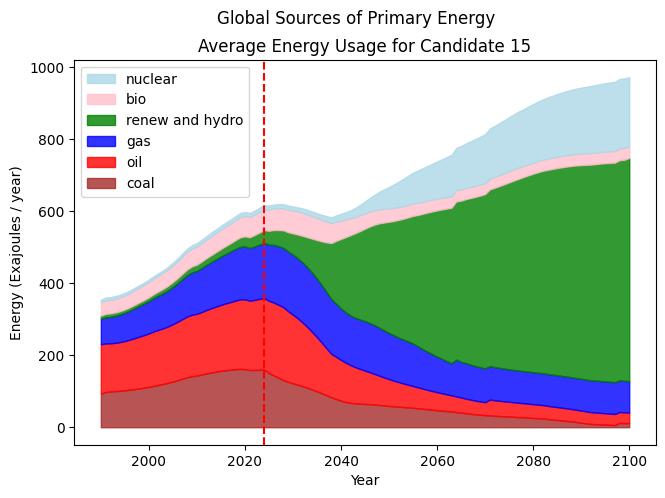

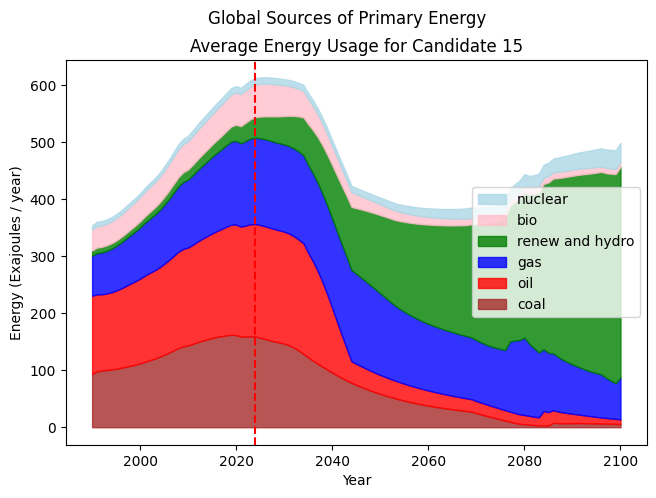

In [21]:
plot_energy_usage([cand_idx], ssp_1_outcomes, baseline_df)
plot_energy_usage([cand_idx], ssp_3_outcomes, baseline_df)

In [22]:
open_context_idx(cand_idx, X, problem, 0)
open_context_idx(cand_idx, X, problem, 1)
open_context_idx(cand_idx, X, problem, 2)
open_context_idx(cand_idx, X, problem, 3)
open_context_idx(cand_idx, X, problem, 4)

### Context Metrics

In [23]:
# Get all metrics over candidate/contexts
all_metrics = []
for cand_context_actions_dicts, cand_outcomes_dfs in zip(all_context_actions_dicts, all_outcomes_dfs):
    metrics = []
    for context_actions_dicts, outcomes_df in zip(cand_context_actions_dicts, cand_outcomes_dfs):
        metrics.append(outcome_manager.process_outcomes(context_actions_dicts, outcomes_df))
    all_metrics.append(metrics)

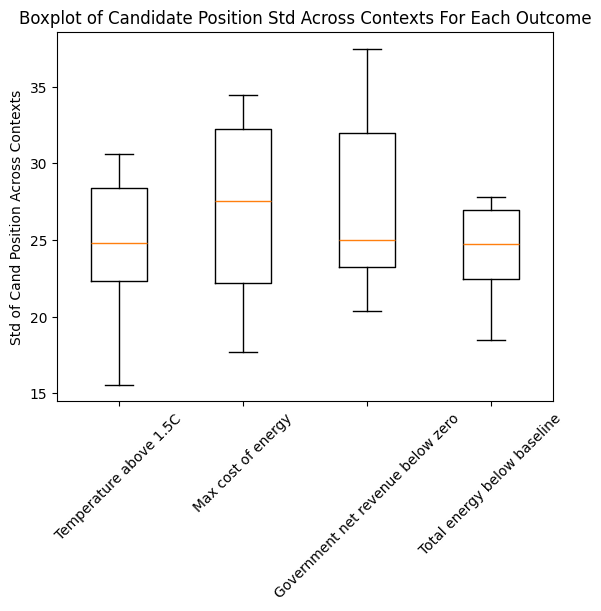

In [68]:
def get_average_position_variance(all_metrics: list[list[dict[str, float]]], outcomes: dict[str, bool]):
    # Acquire array of candidate x context metric values
    metric_list = [[[context_metrics[metric] for metric in outcomes] for context_metrics in cand_metrics] for cand_metrics in all_metrics]
    metric_arr = np.array(metric_list)

    # Get ordering of candidates
    sorted_idxs = np.argsort(metric_arr, axis=0)
    # Get variance of each candidate's position over all the contexts
    idx_vars = np.std(sorted_idxs, axis=1)

    fig, ax = plt.subplots()
    ax.boxplot(idx_vars)
    ax.set_xticklabels(outcomes.keys())
    plt.xticks(rotation=45)
    plt.ylabel("Std of Cand Position Across Contexts")
    plt.title("Boxplot of Candidate Position Std Across Contexts For Each Outcome")
    plt.show()

get_average_position_variance(all_metrics, outcomes)